## Exploratory Data Analysis for Speech Emotion Recognition 

We will explore 3 datasets that are labelled with 7-8 emotions. This notebook is Part 1 of 3 datasets that we will be using for this project. 


The goal of this project is to detect human emotion in audio file using Librosa.

- 1. Load and play sample wav files from three datasets
- 2. Deep dive to Ravdess dataset
    - 2.1 Distribution of data
    - 2.2 Waveform
- 3. Visualize using specshow from Librosa (Feature Extraction)
    - 3.1 Amplitude Envelope
    - 3.2 RMS (ROOT MEAN SQUARE)
    - 3.3 ZERO CROSSING RATE
    - 3.4 Spectral Centroid
    - 3.5 Spectral Rolloff
    - 3.6 MEL Spectogram
    - 3.7 Chroma STFT
    - 3.8 Mel frequency cepstral coefficients (MFCC)

- 4. DATA AUGMENTATION
    - 4.1  Trimming
    - 4.2 Adding Noise 
    - 4.3 Stretching
    - 4.4 Pitch
    
#### SOURCE

[The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976#.YmlBpS8RoTs)

***Description***

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

- For this project, we will only use *Audio-only files*

Audio-only files of all actors (01-24):
Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains ***1440 files***: 60 trials per actor x 24 actors = 1440. 



[Toronto emotional speech set (TESS)](https://tspace.library.utoronto.ca/handle/1807/24487)

***Description***

- These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 stimuli in total.


[Surrey Audio-Visual Expressed Emotion (SAVEE)Database](http://personal.ee.surrey.ac.uk/Personal/P.Jackson/SAVEE/Database.html)

***Description***

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences. 

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#to list the files
from glob import glob

#for Audio processing
from IPython.display import Audio
import librosa
import librosa.display


from sklearn.preprocessing import scale, minmax_scale


In [2]:
#this is to ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### 01. Load and play sample wav files

In [3]:
def get_files(dir):
    
    files = glob(dir + '*/*.wav')
    print(f"{dir} file counts : ", len(files))
        
    return files

In [4]:
def play_librosa(wav_file, source='None'):
    
    print("WAV: ", wav_file)
    
    audio, sfreq = librosa.load(wav_file)
    time = np.arange(0, len(audio)) / sfreq

    print('Sample Rate:', sfreq)
    
    fig, ax = plt.subplots()
    ax.plot(time, audio)
    ax.set(xlabel='Time (sec)',  ylabel='Sound Amplitude')

    return Audio(data=audio, rate=sfreq)

In [5]:
#define the directories/paths
ravdess_rootdir = './raw_source/RAVDESS/'
tess_rootdir = './raw_source/TESS/'
savee_rootdir = './raw_source/Savee/'

In [6]:
#iterate from the dataset collection, get the files, and check how may files for each collection
ravdess = get_files(ravdess_rootdir)
tess =  get_files(tess_rootdir)
savee =  get_files(savee_rootdir)

./raw_source/RAVDESS/ file counts :  1440
./raw_source/TESS/ file counts :  2800
./raw_source/Savee/ file counts :  480


### Let's hear and visualize samples 

WAV:  ./raw_source/RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
Sample Rate: 22050


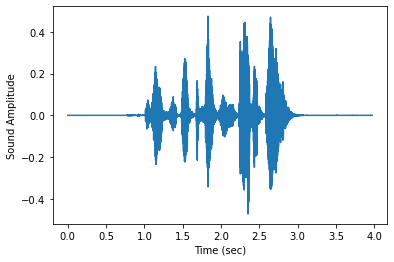

In [7]:
#testing the  WAV from Ravdess
play_librosa(ravdess[3])

WAV:  ./raw_source/TESS/YAF_disgust/YAF_date_disgust.wav
Sample Rate: 22050


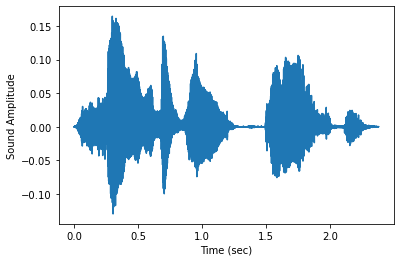

In [8]:
#testing the  WAV  from Tess
play_librosa(tess[0])

WAV:  ./raw_source/Savee/KL/sa05.wav
Sample Rate: 22050


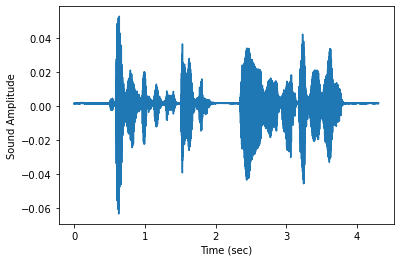

In [9]:
#testing the  WAV from Savee
play_librosa(savee[10])

### 02. We will deep dive into RAVDESS only in the below section, a separate notebook is created for EDA for SAVEE and TESS

# RAVDESS 
Filename identifiers 

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).



***Filename example: 03-01-02-02-02-02-16.wav***

- Audio-only (03)
- Speech (01)
- Calm (02)
- Normal intensity (01)
- Statement "dogs" (02)
- 2nd Repetition (02)
- 16th Actor (16)
- Female, as the actor ID number is even

In [10]:
#lets generate some analysis on the .wav files by getting the audio and the sample rate

ravdess_label = []
ravdess_intensity = []
ravdess_actor = []
ravdess_gender = []
ravdess_sr = []
ravdess_audio = []

for r in ravdess:
    
    #get the emotion part
    ravdess_label.append(r.split("-")[2])
    
    #get the intensity part
    ravdess_intensity.append(r.split("-")[3])
    
    #get the emotion part
    ravdess_actor.append(r.split("-")[6])
    
    #librosa output
    audio, sr = librosa.load(r)
    
    
    ravdess_audio.append(audio)
    ravdess_sr.append(sr)

In [11]:
#convert the data into dataframe
data = {'file':ravdess, 
        'label':ravdess_label, 
        'intensity': ravdess_intensity, 
        'actor': ravdess_actor,
        'sr':ravdess_sr,
        'audio':ravdess_audio}
df_ravdes = pd.DataFrame(data)

In [12]:
#lets check if the dataframe is successfully created
df_ravdes.head()

,file,label,intensity,actor,sr,audio
0,./raw_source/RAVDESS/Actor_16/03-01-05-01-02-0...,05,01,16.wav,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,./raw_source/RAVDESS/Actor_16/03-01-06-01-02-0...,06,01,16.wav,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,./raw_source/RAVDESS/Actor_16/03-01-06-02-01-0...,06,02,16.wav,22050,"[3.0036153e-05, 2.7443759e-05, 9.890327e-07, 6..."
3,./raw_source/RAVDESS/Actor_16/03-01-05-02-01-0...,05,02,16.wav,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,./raw_source/RAVDESS/Actor_16/03-01-07-01-01-0...,07,01,16.wav,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
#map the label into actual emotions or descriptions for easy analysis

dict_emotion = {
    
    "01" : "neutral", 
    "02" : "calm", 
    "03" : "happy",
    "04" : "sad",
    "05" : "angry",
    "06" : "fearful",
    "07" : "disgust", 
    "08" : "surprised"
    
}

df_ravdes["emotion"] = df_ravdes["label"].map(dict_emotion)

#### 2.1 Distribution of Data

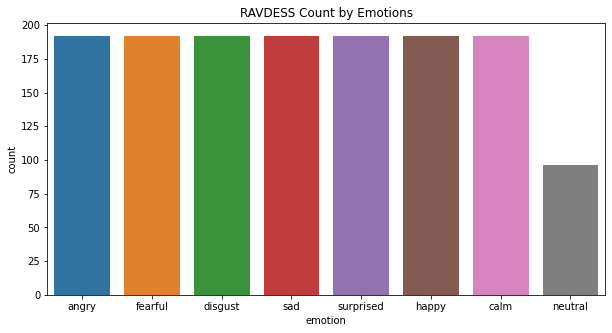

In [14]:
#distribution of the data
plt.figure(figsize=(10,5))
sns.countplot(data = df_ravdes, x="emotion")
plt.title("RAVDESS Count by Emotions")
plt.savefig("./image/ravdess_dist.png")

*Evenly distributed except for neutral with < 100 samples*

In [15]:
#sample rate is consistent to be 22.050KHz
df_ravdes["sr"].unique()

array([22050])

In [16]:
#check the lenght of the audio file
df_ravdes["audio_len"] = df_ravdes["audio"].map(lambda x: len(x))

In [17]:
#create a time period, how many seconds per wav file
df_ravdes["audio_freq"] = df_ravdes["audio_len"] / df_ravdes["sr"]

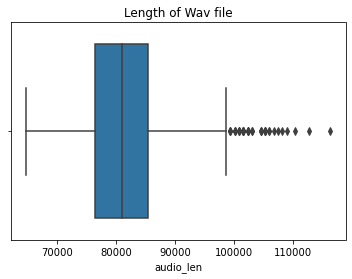

In [18]:
sns.boxplot(data = df_ravdes, x="audio_len")
plt.title("Length of Wav file");

In [19]:
df_ravdes.groupby(by=["emotion"])[["emotion", "audio_len"]].mean()

,audio_len
emotion,
angry,85364.963542
calm,83698.083333
disgust,86916.817708
fearful,78812.291667
happy,80222.427083
neutral,77245.020833
sad,81464.000000
surprised,76900.156250


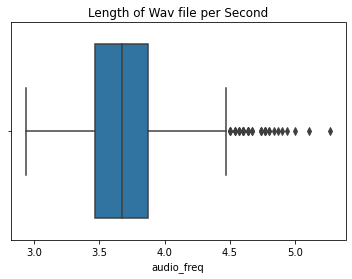

In [20]:
sns.boxplot(data = df_ravdes, x="audio_freq")
plt.title("Length of Wav file per Second");
plt.savefig("./image/ravdess_box.png")

*The average length of audio is between 3 to 4 seconds*

### 2.2 Waveform

*Visualize a waveform in the time domain*

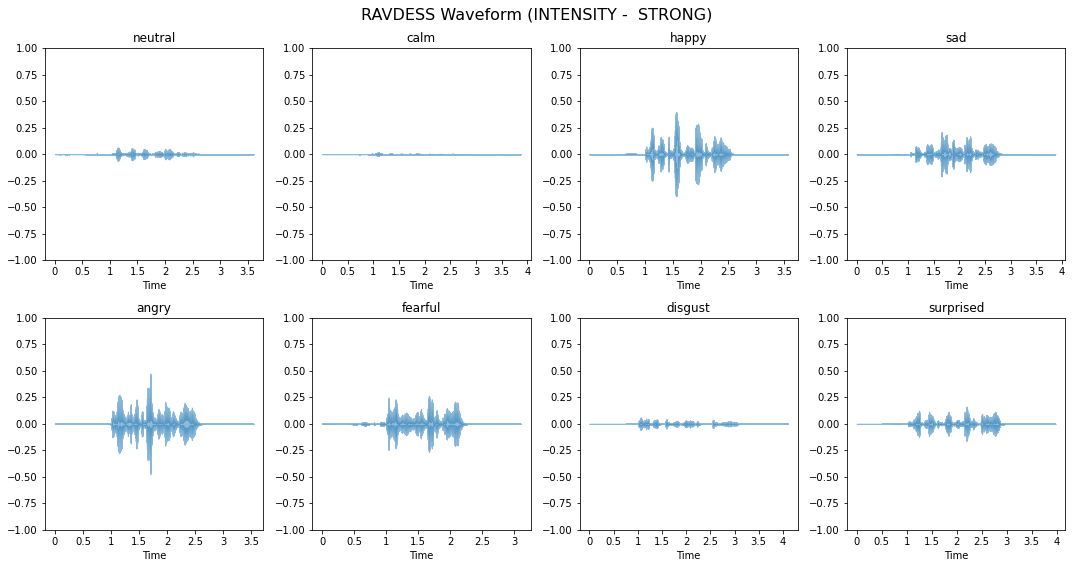

In [21]:
#waveform visualization

ls_emotion = ["neutral", "calm", "happy", "sad","angry", "fearful", "disgust","surprised"]
viz_strong= []

for emo in ls_emotion:
    
    if emo == 'neutral':#neutral has no strong emotion
        viz_strong.append(df_ravdes[(df_ravdes["emotion"] == emo) & (df_ravdes["intensity"]=='01')].sample(n=1).iloc[0])
    else:
        viz_strong.append(df_ravdes[(df_ravdes["emotion"] == emo) & (df_ravdes["intensity"]=='02')].sample(n=1).iloc[0])

        
plt.figure(figsize=(15, 8))

for x in range(len(viz_strong)):
    plt.subplot(2,4,x+1)
    librosa.display.waveshow(viz_strong[x]["audio"], sr=viz_strong[x]["sr"],alpha=0.5)
    plt.title(viz_strong[x]["emotion"])
    plt.ylim((-1, 1))

plt.suptitle("RAVDESS Waveform (INTENSITY -  STRONG)", size=16);
plt.tight_layout()
plt.savefig("./image/ravdess_intensity_all.png")

**Y limit is the same for all, and angry  has the highest intensity from range -1 to 1. There is also a lot of noise before and after, and the actual sounds might be 2 to 3 seconds only**

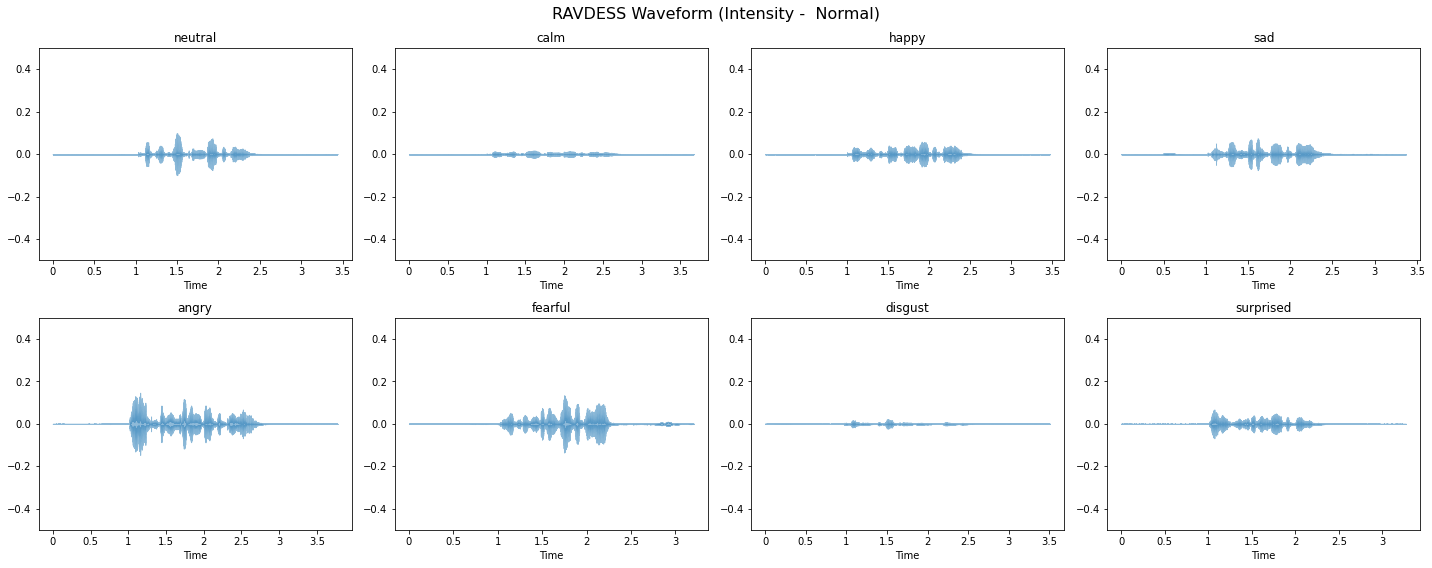

In [22]:
#waveform visualization

ls_emotion = ["neutral", "calm", "happy", "sad","angry", "fearful", "disgust","surprised"]
viz_normal = []

for emo in ls_emotion:
    viz_normal.append(df_ravdes[(df_ravdes["emotion"] == emo) & (df_ravdes["intensity"]=='01')].sample(n=1).iloc[0])
    

plt.figure(figsize=(20, 8))

for x in range(len(viz_normal)):
    plt.subplot(2,4,x+1)
    librosa.display.waveshow(viz_normal[x]["audio"], sr=viz_normal[x]["sr"],alpha=0.5)
    plt.title(viz_normal[x]["emotion"])
    plt.ylim((-0.5, 0.5))
    
plt.suptitle("RAVDESS Waveform (Intensity -  Normal)", size=16);
plt.tight_layout()
plt.savefig("./image/ravdess_normal.png")

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [23]:
#MALE VS FEMALE -- angry/INTENSITY

angry_female_normal = df_ravdes[(df_ravdes["emotion"] == "angry") & (df_ravdes["intensity"]=='01')  & (df_ravdes["actor"]=='16.wav')].sample(n=1).iloc[0]
angry_female_strong = df_ravdes[(df_ravdes["emotion"] == "angry") & (df_ravdes["intensity"]=='02') & (df_ravdes["actor"]=='16.wav')].sample(n=1).iloc[0]

angry_male_normal = df_ravdes[(df_ravdes["emotion"] == "angry")  & (df_ravdes["intensity"]=='01') & (df_ravdes["actor"]=='17.wav')].sample(n=1).iloc[0]
angry_male_strong = df_ravdes[(df_ravdes["emotion"] == "angry") & (df_ravdes["intensity"]=='02') & (df_ravdes["actor"]=='17.wav')].sample(n=1).iloc[0]

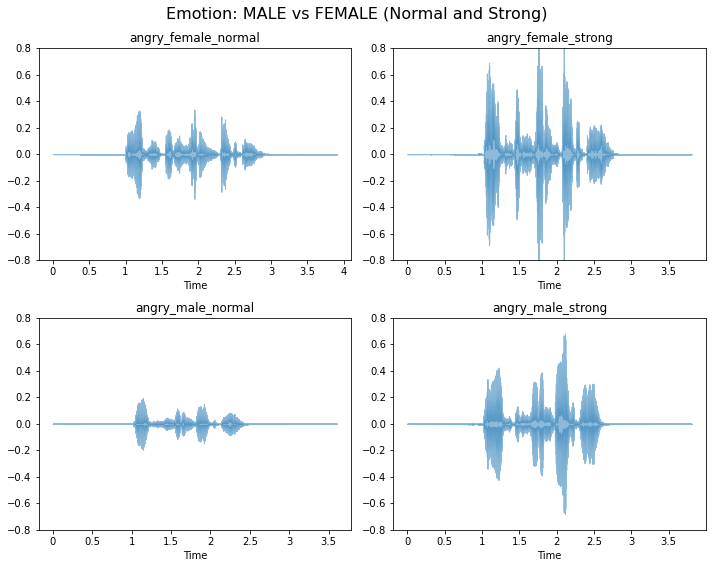

In [24]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
librosa.display.waveshow(angry_female_normal["audio"], sr=angry_female_normal["sr"],alpha=0.5)
plt.ylim((-0.8, 0.8))
plt.title("angry_female_normal")

plt.subplot(2,2,2)
librosa.display.waveshow(angry_female_strong["audio"], sr=angry_female_strong["sr"],alpha=0.5)
plt.ylim((-0.8, 0.8))
plt.title("angry_female_strong")

plt.subplot(2,2,3)
librosa.display.waveshow(angry_male_normal["audio"], sr=angry_male_normal["sr"],alpha=0.5)
plt.ylim((-0.8, 0.8))
plt.title("angry_male_normal")

plt.subplot(2,2,4)
librosa.display.waveshow(angry_male_strong["audio"], sr=angry_male_strong["sr"],alpha=0.5)
plt.ylim((-0.8, 0.8))
plt.title("angry_male_strong")

plt.suptitle("Emotion: MALE vs FEMALE (Normal and Strong)", size=16)
plt.tight_layout()
plt.savefig("./image/ravdess_male_female.png")

## 3. Exploratory Data Analysis from Feature Extraction

### 3.1 Amplitude Envelope
- Max amplitude value of all samples in a frame

In [25]:
def fancy_amplitude_envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])
    

In [26]:
FRAME_SIZE = 512
HOP_LENGTH = 256

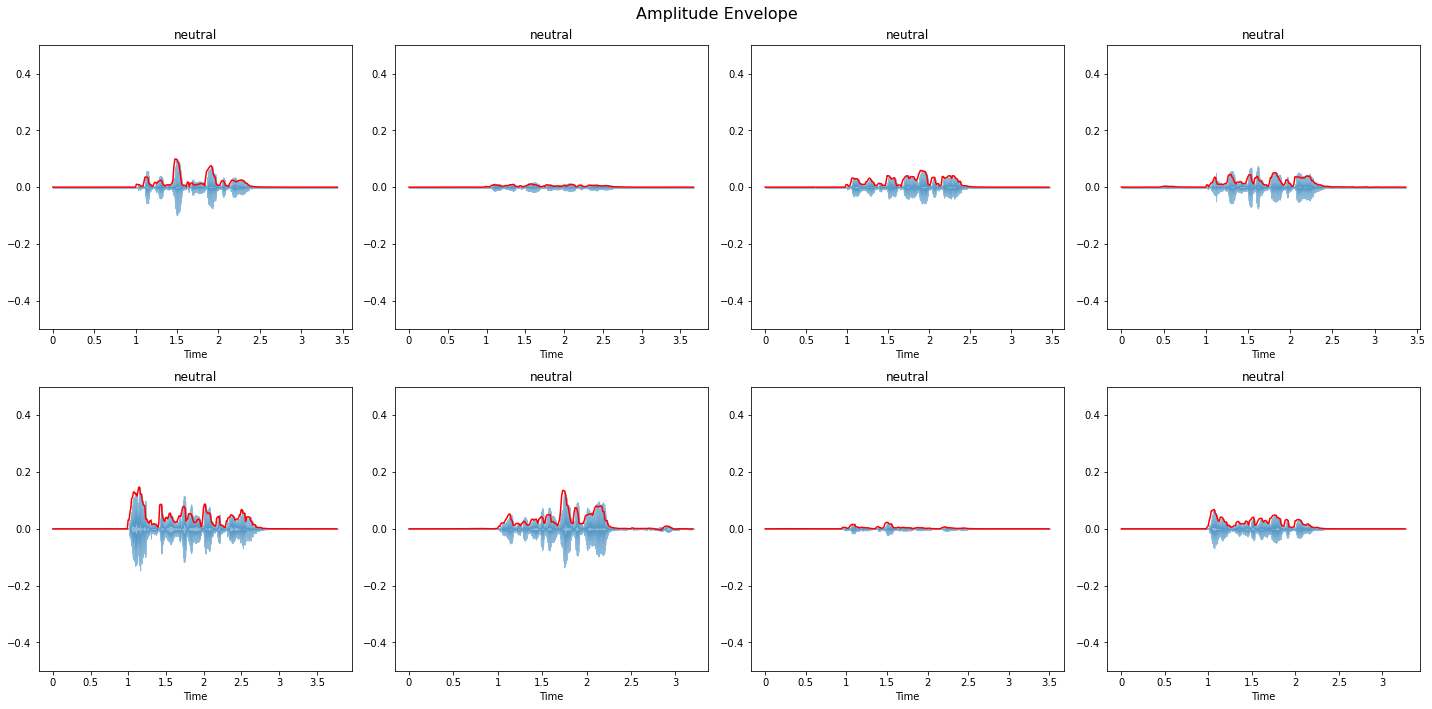

In [27]:

plt.figure(figsize=(20, 10))

for x in range(len(viz_normal)):
    plt.subplot(2,4,x+1)
    librosa.display.waveshow(viz_normal[x]["audio"], sr=viz_normal[x]["sr"],alpha=0.5)
    
    ae_normal = fancy_amplitude_envelope(viz_normal[x]["audio"], FRAME_SIZE, HOP_LENGTH)
    
    frames = range(len(ae_normal))
    t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
    plt.plot(t, ae_normal, color="r")

    plt.title(viz_normal[0]["emotion"])
    plt.ylim((-.5, .5))

plt.suptitle("Amplitude Envelope", size=16);
plt.tight_layout()


### 3.2 RMS (ROOT MEAN SQUARE)

Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.

- Indicator of loudness

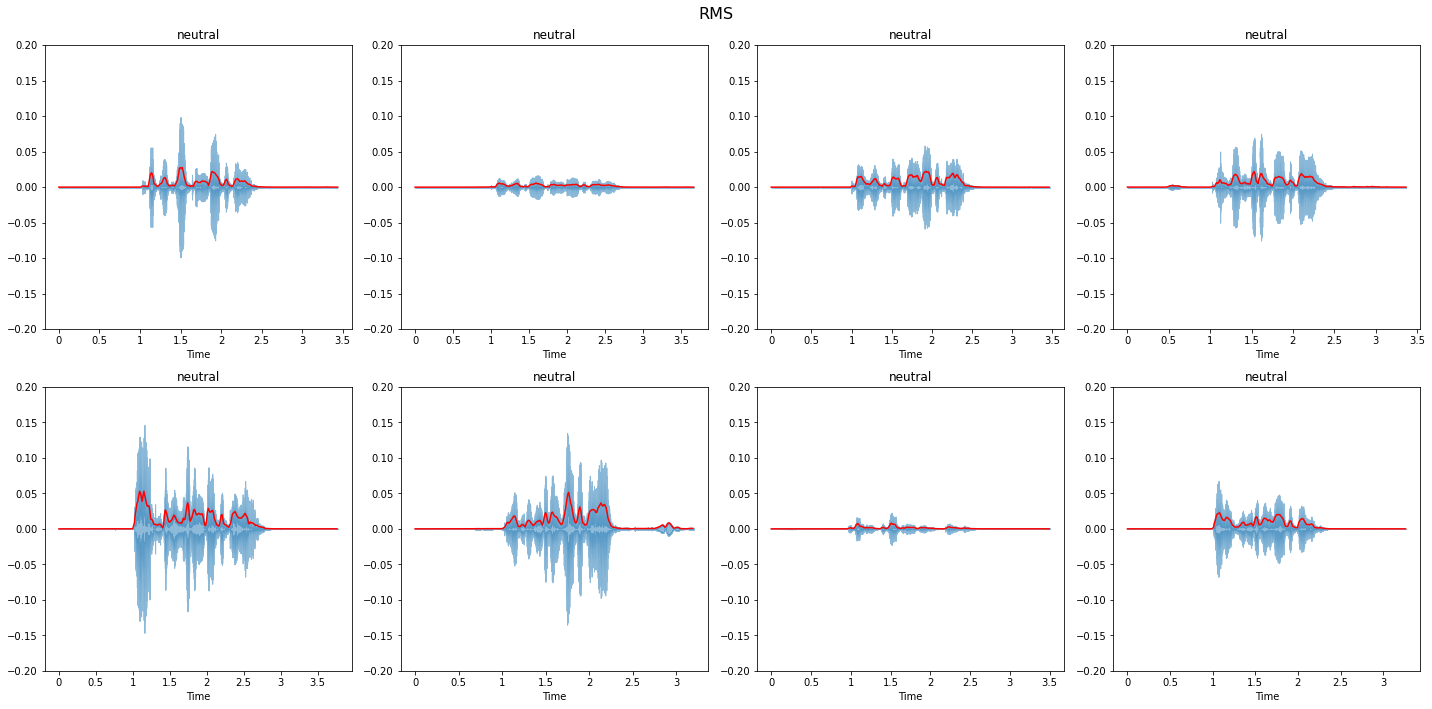

In [28]:

plt.figure(figsize=(20, 10))

for x in range(len(viz_normal)):
    plt.subplot(2,4,x+1)
    librosa.display.waveshow(viz_normal[x]["audio"], sr=viz_normal[x]["sr"],alpha=0.5)
    
    rmse = librosa.feature.rms(y=viz_normal[x]["audio"], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    
    frames = range(len(rmse[0]))
    t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
    plt.plot(t, rmse[0], color="r")

    plt.title(viz_normal[0]["emotion"])
    plt.ylim((-.2, .2))

plt.suptitle("RMS", size=16);
plt.tight_layout()
plt.savefig("./image/ravdess_rms.png")


### 3.3 ZERO CROSSING RATE

- Number of times a signal crosses the horizontal axis

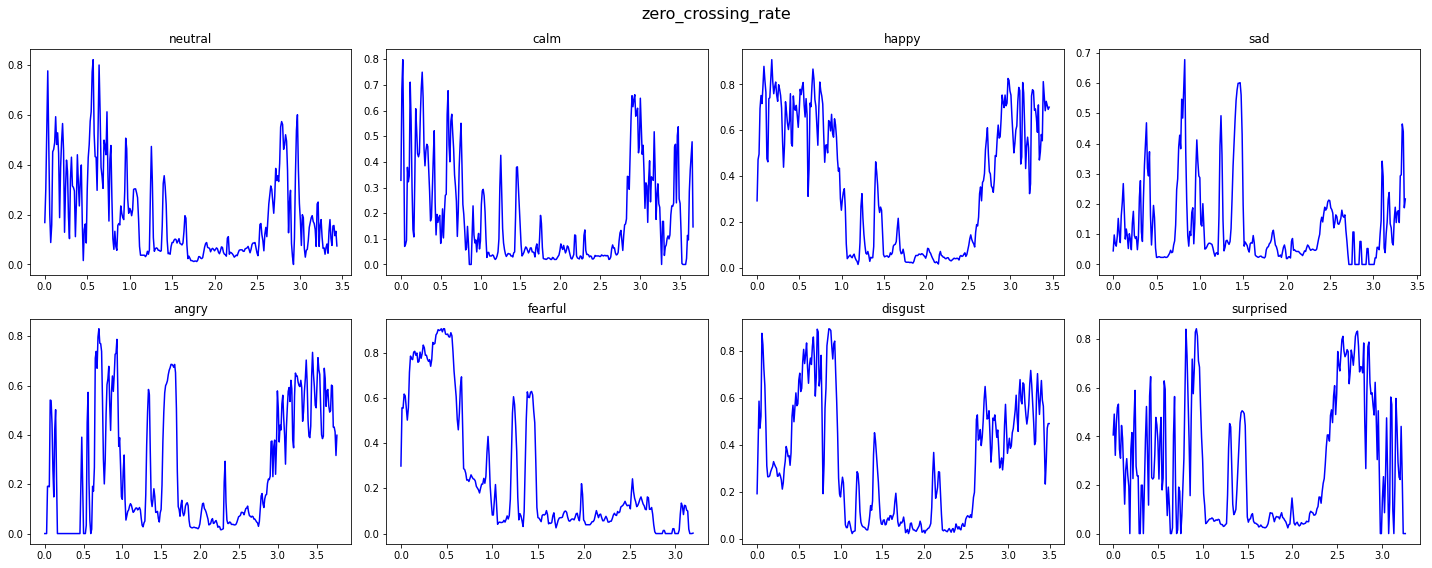

In [29]:

plt.figure(figsize=(20, 8))

for x in range(len(viz_normal)):
    plt.subplot(2,4,x+1)    
    
    crossing = librosa.feature.zero_crossing_rate(y=viz_normal[x]["audio"], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    
    frames = range(len(crossing[0]))
    t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
    plt.plot(t, crossing[0], color="b")

    plt.title(viz_normal[x]["emotion"])
    #plt.ylim((-.1, .1))

plt.suptitle("zero_crossing_rate", size=16);
plt.tight_layout()
plt.savefig("./image/rav_zero_crossing_rate.png")



### 3.4 Spectral Centroid

- Spectral centroid indicates where the ”center of mass” for a sound is located
- Calculated as the weighted mean of the frequencies present in the sound.

In [30]:
sample_rate=22050

In [31]:
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

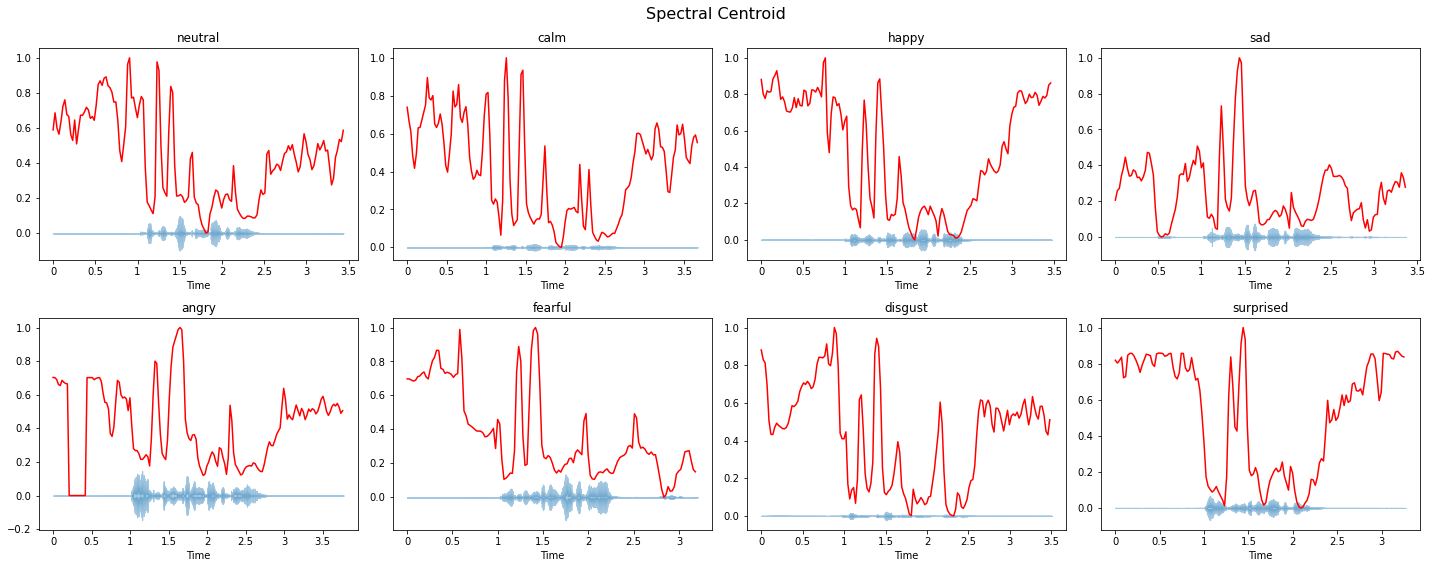

In [32]:

plt.figure(figsize=(20, 8))

for x in range(len(viz_normal)):
    plt.subplot(2,4,x+1)    
    
    centroid = librosa.feature.spectral_centroid(y=viz_normal[x]["audio"], sr=viz_normal[x]["sr"])
    t = librosa.frames_to_time(range(len(centroid[0])))
    
    librosa.display.waveshow(viz_normal[x]["audio"], sr=sample_rate, alpha=0.4)
    plt.plot(t, normalize(centroid[0]), color='r')

    plt.title(viz_normal[x]["emotion"])

    #print(viz_normal[x]["emotion"], centroid.mean())


plt.suptitle("Spectral Centroid", size=16);
plt.tight_layout()
plt.savefig("./image/spectral_centroid.png")



### 3.5 Spectral Rolloff

Spectral rolloff is a measure of the shape of the signal.
It represents the frequency below which a specified percentage of the total spectral energy

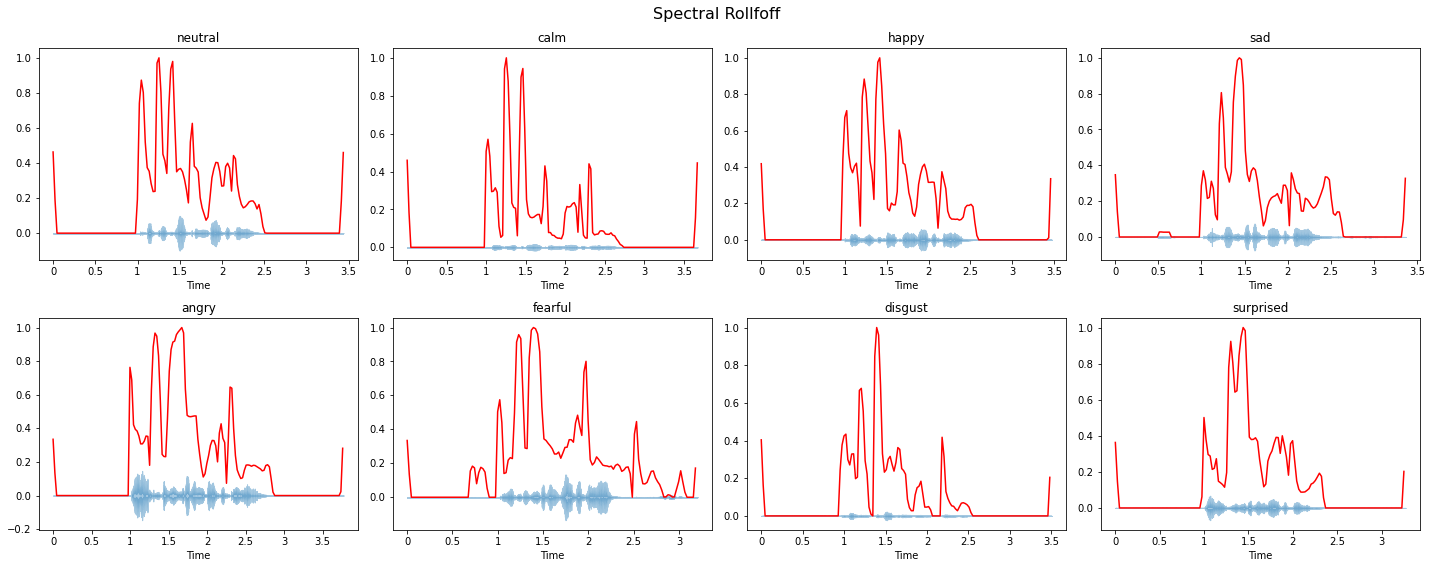

In [33]:

plt.figure(figsize=(20, 8))

for x in range(len(viz_normal)):
    plt.subplot(2,4,x+1)    
    
    rolloff = librosa.feature.spectral_rolloff(y=viz_normal[x]["audio"] + 0.01, sr=viz_normal[x]["sr"])
    t = librosa.frames_to_time(range(len(rolloff[0])))
    
    librosa.display.waveshow(viz_normal[x]["audio"], sr=sample_rate, alpha=0.4)
    plt.plot(t, normalize(rolloff[0]), color='r')

    plt.title(viz_normal[x]["emotion"])

    #print(viz_normal[x]["emotion"], rolloff.mean())


plt.suptitle("Spectral Rollfoff", size=16);
plt.tight_layout()
plt.savefig("./image/spectral_rolloff.png")


### 3.6 MEL Spectogram

- Compute a mel-scaled spectrogram

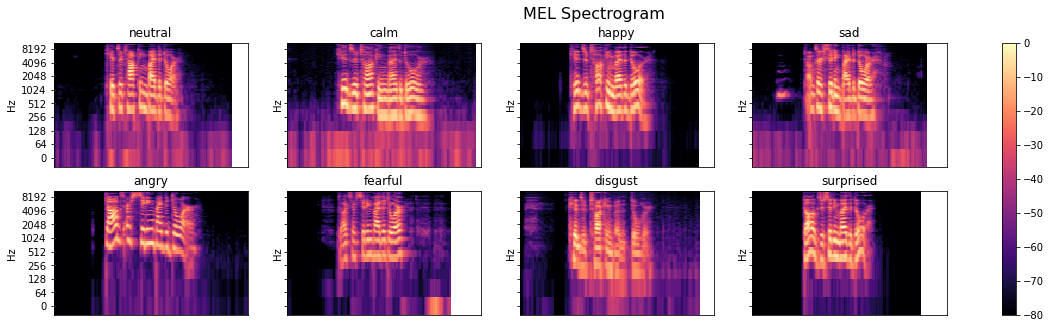

In [34]:

fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(20,5))

for x in range(len(viz_normal)):
    
    r = np.int64(np.floor(x/4))
    c = x%4
    
    mel_features = librosa.feature.melspectrogram(viz_normal[x]["audio"], sr=sample_rate)
    log_mel_features = librosa.power_to_db(mel_features, ref=np.max)

    img = librosa.display.specshow(log_mel_features, y_axis="log", ax=ax[r,c])
    ax[r,c].set(title=viz_normal[x]["emotion"])
          

fig.colorbar(img, ax=ax)

plt.suptitle("MEL Spectrogram", size=16);

plt.savefig("./image/rav_spectogram.png")


### 3.7 Chroma STFT

- Compute a chromagram from a waveform or power spectrogram.

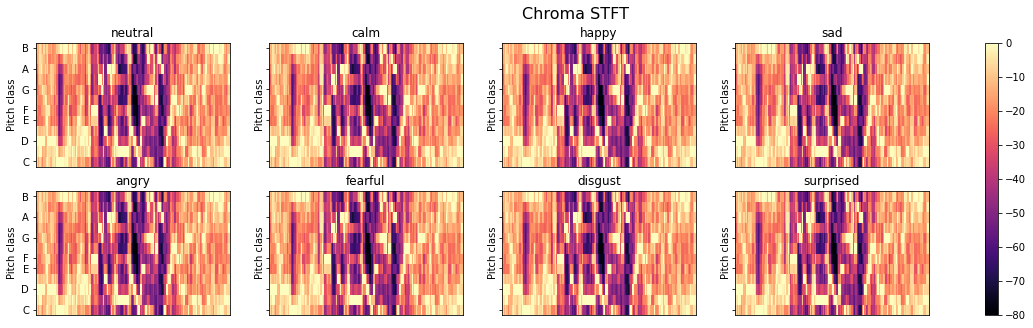

In [35]:

fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(20,5))

for x in range(len(viz_normal)):
    
    r = np.int64(np.floor(x/4))
    c = x%4
    
    S = np.abs(librosa.stft(viz_normal[0]["audio"]))
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    librosa.display.specshow(chroma, y_axis='chroma',  ax=ax[r,c])
    
    ax[r,c].set(title=viz_normal[x]["emotion"])
    

fig.colorbar(img, ax=ax)
plt.suptitle("Chroma STFT", size=16);
plt.savefig("./image/rav_chromagram.png")



### 3.8 Mel frequency cepstral coefficients (MFCC)

The MFCCs of a signal are a small set of features (usually about 10–20) that concisely describe the overall shape of a spectral envelope.
So in given 10 to 20 feature set, the music information is packed for the all music frames
It models the characteristics of the human voice.

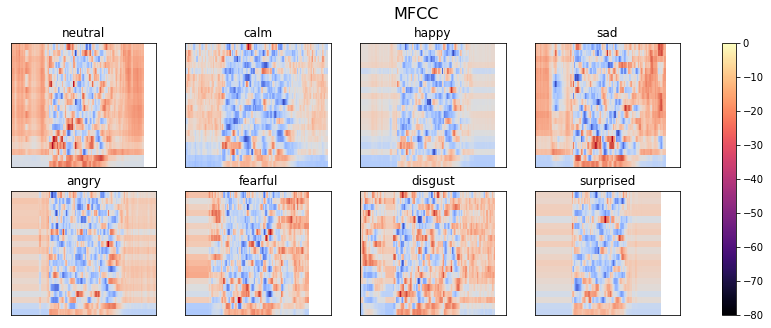

In [36]:

fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(15,5))

for x in range(len(viz_normal)):
    
    r = np.int64(np.floor(x/4))
    c = x%4
    
    mfccs = librosa.feature.mfcc(y=viz_normal[x]["audio"], sr=viz_normal[x]["sr"])
    mfccs = scale(mfccs, axis=1)
    
    librosa.display.specshow(mfccs, sr=viz_normal[x]["sr"],  ax=ax[r,c])
    ax[r,c].set(title=viz_normal[x]["emotion"])
    

fig.colorbar(img, ax=ax)
plt.suptitle("MFCC", size=16);
plt.savefig("./image/rav_mfcc.png")


##  4.0 DATA AUGMENTATION

In [37]:
##functions for data augmentation

#default values
v_random_noise = 0.05

v_stretch_rate = 0.9

v_shift_low = -10
v_shift_high = 10

v_pitch_factor = 0.9

def add_noise(data):
    noise_amp = v_random_noise*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def add_stretch(data, rate=v_stretch_rate):
    return librosa.effects.time_stretch(data, rate=rate)

def add_pitch(data, sampling_rate=sample_rate, pitch_factor= v_pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [38]:
#let's pick one emotion
viz_normal[4]["emotion"]
data, sample_rate = librosa.load(viz_normal[4]["file"]) 

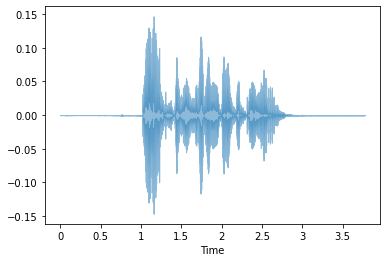

In [39]:
#waveform
librosa.display.waveshow(data, sr=viz_normal[x]["sr"],alpha=0.5)

#listen to the original Audio
Audio(viz_normal[4]["audio"], rate=sample_rate)

### 4.1  Trimming (removing silence from the beginning and ending)

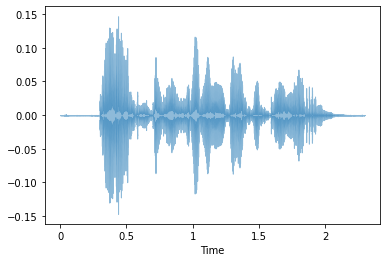

In [40]:
#Trim leading and trailing silence from an audio signal.
yt, index = librosa.effects.trim(data)

#waveform
librosa.display.waveshow(yt, sr=viz_normal[x]["sr"],alpha=0.5)

#trimmed
Audio(yt, rate=sample_rate)

### 4.2 Adding Noise 

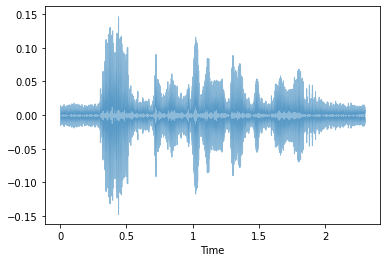

In [41]:
#adding NOISE
with_noise = add_noise(yt)

librosa.display.waveshow(with_noise, sr=viz_normal[x]["sr"],alpha=0.5)

Audio(with_noise, rate=sample_rate)

### 4.3 Stretching

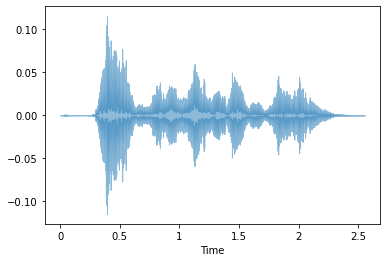

In [42]:
#STRETCHING
with_stretch = add_stretch(yt)

librosa.display.waveshow(with_stretch, sr=viz_normal[x]["sr"],alpha=0.5)

Audio(with_stretch, rate=sample_rate)

### 4.4 Pitch

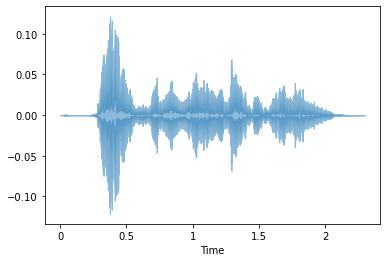

In [43]:
#ADDING PITCH
with_pitch = add_pitch(yt)

librosa.display.waveshow(with_pitch, sr=viz_normal[x]["sr"],alpha=0.5)

Audio(with_pitch, rate=sample_rate)

REFERENCE MATERIALS: [Audio Signal Processing for Machine Learning](https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=1)